### Imports

In [1]:
import os
import re
import shutil
import sys
from datetime import date
import time
import tempfile

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle
import matplotlib as mpl
from itertools import cycle

from skimage import io
from scipy import signal

from scipy import sparse
from sklearn.cluster import OPTICS, DBSCAN, AffinityPropagation
from sklearn import neighbors

# local imports
from image_arrays import *
from interactive import *
from hdf_utils import pack_hdf, unpack_hdf
from fitting import BiexpFitter
from s2p_packer import pixels_to_beams
from ROIExplorer import ROIExplorer

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** interactive figures (jupyter notebook)
- **widget ->** interactive figures (jupyter lab)

In [2]:
# %matplotlib qt 
# %matplotlib notebook
%matplotlib widget
# %matplotlib ipympl

### Paths describing folder structure used for loading in videos and data archives
These, along with naming of the files when they come up, should be altered to align with your setup.

In [3]:
s2p_env = "~/miniconda3/envs/suite2p"
s2p_runner = "~/git/imaging-utils/s2p_runner.py"
# data_path = "/mnt/Data/prerna_noise/spontaneous_s2p/"
data_path = "/mnt/Data/prerna_noise/spontaneous_s2p_h5/"
# data_path = "/mnt/Data/prerna_noise/s2p_chirp_processed_4x4/"

hdf_mode = None
if hdf_mode is None:
    is_hdf = (
        os.path.splitext(n)[1] == ".h5" 
        for n in os.listdir(data_path) 
        if os.path.isfile(os.path.join(data_path, n))
    )
    if all(is_hdf):
        hdf_mode = True
    elif all((not b for b in is_hdf)):
        hdf_mode = False
    else:
        ValueError("hdf_mode must be specified if data_path is mixed")

if hdf_mode:
    def unpack(pth):
        with h5.File(pth) as f:
            data = unpack_hdf(f)["stack"]
        return data

    stacks = np.stack(
        [
            unpack(os.path.join(data_path, f))
            for f in os.listdir(data_path) 
            if f.endswith(".h5")
        ],
        axis=0
    )
else:
    stacks = np.stack(
    [
        io.imread(os.path.join(data_path, f))
        for f in os.listdir(data_path) 
        if (f.endswith(".tiff") or f.endswith(".tif"))
    ],
    axis=0
)

mean_stack_proj = np.mean(stacks, axis=(0, 1))
n_trials, n_frames, n_rows, n_cols = stacks.shape 

# hz = 58.2487
hz = 208.5
dt = 1 / hz
recs_xaxis = np.arange(n_frames) * dt

# physical dimensions (in microns)
rec_width = 71.7
rec_height = 28.94
pix_w = rec_width / n_cols
pix_h = rec_height / n_rows
rec_extent = (0, rec_width, rec_height, 0)  # for scaling imshow plots

print("stacks shape:", stacks.shape)

stacks shape: (1, 8000, 60, 256)


### Dynamic ROI plot of recordings
Trial to display in the stack axis can be selected with the slider, with the last position being the average. Use mouse scroll to cycle through frames of the movies. Beams of the outlined ROI are displayed below with the current trial highlighted in red. The average beam is displayed with a thicker linewidth and greater opacity.

**NOTE:** If the recordings are large, this will use up a lot of RAM.

Recording shape: (8000, 60, 256)


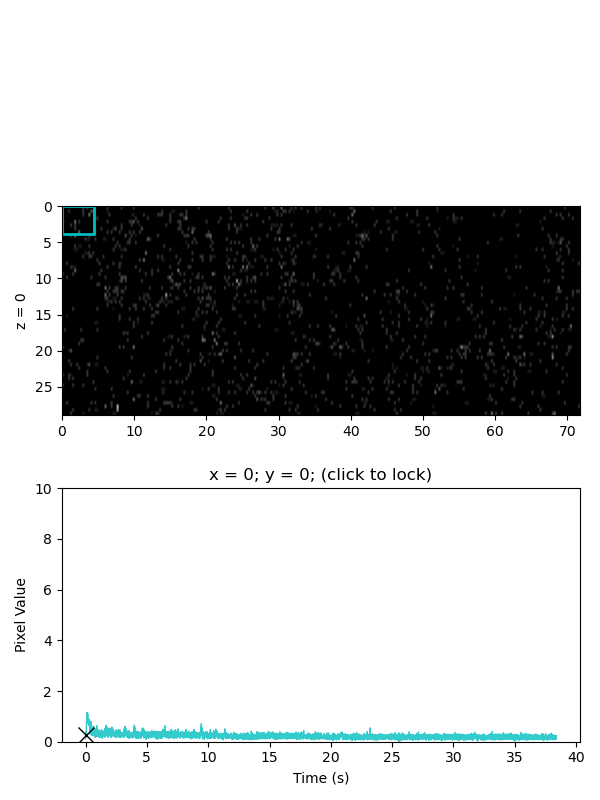

In [24]:
stacks_plot = ROIExplorer(
    stacks,
    zaxis=recs_xaxis,
    delta=5,
#     roi_sz=(8, 6),
    roi_sz=(16, 8),
#     vmin=0,
#     auto_roi_scale=True,
    dims=(rec_width, rec_height),
    trial_width=1,
    figsize=(6, 8)
)
stacks_plot.ax[1].set_xlabel("Time (s)")
stacks_plot.ax[1].set_ylabel("Pixel Value")

print("Recording shape:", stacks[0].shape)
# stacks_plot.fig.show()
stacks_plot.fig.tight_layout()

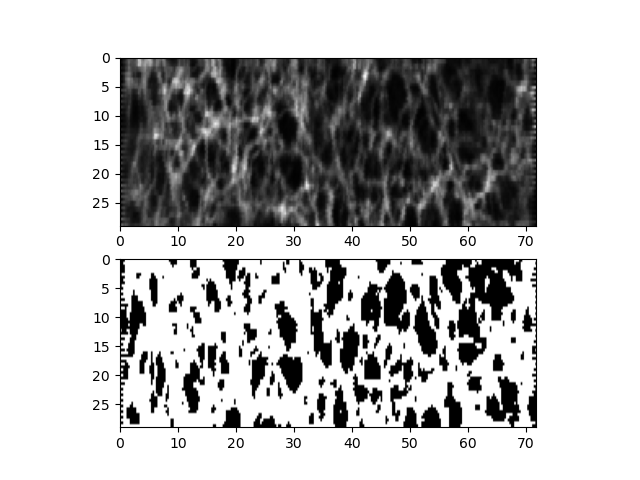

In [5]:
mean_thresh = 0.1
mean_proj_fig, mean_proj_ax = plt.subplots(2)
mean_proj_ax[0].imshow(mean_stack_proj, cmap="gray", extent=rec_extent)
mean_proj_ax[1].imshow(mean_stack_proj > mean_thresh, cmap="gray", extent=rec_extent)

In [6]:
# rad_w = 6
# rad_h = 6
rad_w = 8
rad_h = 8

# stck = stacks[0, 4000:7000]
# stck = stacks[0]
stck = rolling_average(stacks[0].transpose(1, 2, 0)).transpose(2, 0, 1)

mid_idx = stck.shape[0] // 2
# win_dur = 0.02
# win_pts = int(win_dur * hz)
win_pts = 0
win_pad = np.zeros((win_pts, *stck.shape[1:]))
padded = np.concatenate([win_pad, stck, win_pad])

incl_pos_to_coords, incl_pos_to_idx = [], []
incl_coords_to_pos, incl_idx_to_pos = {}, {}
drop_coords = {}
def mean_check(coords):
    row, col = coords  # <---------- This line was missing.
    if coords in incl_coords_to_pos:
        return True
    elif coords in drop_coords:
        return False
    if mean_stack_proj[row, col] > mean_thresh:
        incl_coords_to_pos[coords] = len(incl_pos_to_coords)
        incl_pos_to_coords.append(coords)
        idx = row * n_cols + col
        incl_idx_to_pos[idx] = len(incl_pos_to_coords)
        incl_pos_to_idx.append(idx)
        return True
    else:
        drop_coords[coords] = True
        return False
    

t0 = time.time()
pix_corrs = {}
n_rows, n_cols = stck.shape[1:]
for row in range(n_rows):
    for col in range(n_cols):
        outer = (row, col)
        if not mean_check(outer):
            continue       
        pix_corrs[outer] = {}
        w0 = max(0, col - rad_w)
        wn = min(n_cols, col + rad_w + 1)
        h0 = max(0, row - rad_h)
        hn = min(n_rows, row + rad_h + 1)
        for w in range(w0, wn):
            for h in range(h0, hn):
                inner = (h, w)
                if (w == col and h == row) or not mean_check(inner):
                    continue
                if inner in pix_corrs and outer in pix_corrs[inner]:
                    pix_corrs[outer][inner] = pix_corrs[inner][outer]
                else:
                    corr = np.correlate(stck[:, row, col], padded[:, h, w], mode="valid")
                    # pix_corrs[outer][inner] = np.sum(corr)
                    pix_corrs[outer][inner] = np.mean(corr)

print("ran in %fs" % (time.time() - t0))
print("included %i pixels of %i" % (len(incl_coords_to_pos), n_cols * n_rows))

ran in 77.168928s
included 10206 pixels of 15360


In [7]:
blocks = []
for (row, col), inners in pix_corrs.items():
    block = np.zeros((rad_h * 2 + 1, rad_w * 2 + 1))
    for (h, w), corr in inners.items():
        br = h - row + rad_h
        bc = w - col + rad_w
        block[br, bc] = corr
    blocks.append(block)
blocks = np.stack(blocks, axis=0)

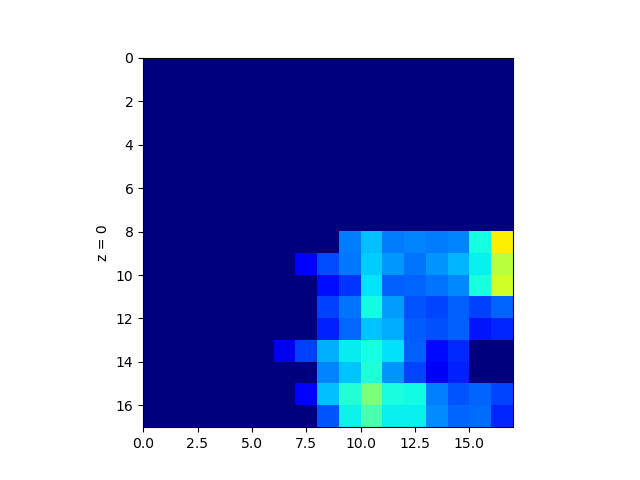

In [8]:
block_fig, block_ax = plt.subplots(1)
block_plot = StackPlotter(
    block_fig,
    block_ax,
    blocks,
    delta=1,
    vmin=0,
    vmax=1000,
    # z_fmt_fun=roi_fmt_fun,
    cmap="jet",
    # dims=(stim_width, stim_height),
)

In [9]:
corr_mat = np.zeros((len(incl_coords_to_pos), len(incl_coords_to_pos)))
for (out_row, out_col), inners in pix_corrs.items():
    out = incl_coords_to_pos[(out_row, out_col)]
    for (in_row, in_col), corr in inners.items():
        corr_mat[out, incl_coords_to_pos[(in_row, in_col)]] = corr

In [10]:
# correlation_matrix_fig, correlation_matrix_ax = plt.subplots(1)
# correlation_matrix_ax.imshow(corr_mat)

In [11]:
t0 = time.time()
sparse_dist = sparse.csr_matrix(1 - (corr_mat / corr_mat.max()))
# sparse_dist = sparse.csr_matrix(1 - (corr_mat / corr_mat.max(axis=0, keepdims=True)))
neighbors.sort_graph_by_row_values(sparse_dist, warn_when_not_sorted=False)
clust = OPTICS(min_samples=50, metric="precomputed", cluster_method="xi", xi=0.).fit(sparse_dist)
print("time to cluster:", time.time() - t0)
print("n clusters:", np.unique(clust.labels_).size - 1)

time to cluster: 12.491215944290161
n clusters: 23


In [12]:
roi_idxs = {}
for i, lbl in enumerate(clust.labels_):
    if lbl < 0:
        continue
    if lbl not in roi_idxs:
        roi_idxs[lbl] = {"x": [], "y": []}
    row, col = incl_pos_to_coords[i]
    roi_idxs[lbl]["x"].append(row)
    roi_idxs[lbl]["y"].append(col)

roi_idxs = {
    lbl: {"x": np.array(pix["x"]), "y": np.array(pix["y"]), "weights": np.ones(len(pix["x"]))}
    for lbl, pix in roi_idxs.items()
}

In [13]:
masks = np.zeros((len(roi_idxs), n_rows, n_cols))
for lbl, pix in roi_idxs.items():
    masks[lbl, pix["x"], pix["y"]] = pix["weights"]

In [14]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
rgb_cycle = cycle([mpl.colors.to_rgba(c) for c in colors])

alpha = 0.4
rgba_mat = np.stack([next(rgb_cycle) for _ in range(masks.shape[0])], axis=0)
rgba_mat[:, 3] = alpha
masks_rgba = np.expand_dims(rgba_mat, (1, 2)) * np.expand_dims(masks, 3)

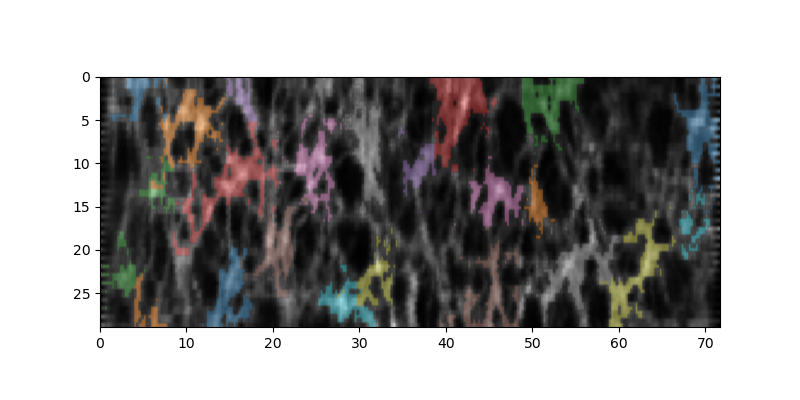

In [15]:
roi_masks_fig, roi_masks_ax = plt.subplots(1, figsize=(8, 4))
roi_masks_ax.imshow(mean_stack_proj, cmap="gray", extent=rec_extent)
roi_masks_ax.imshow(masks_rgba.sum(axis=0), extent=rec_extent)

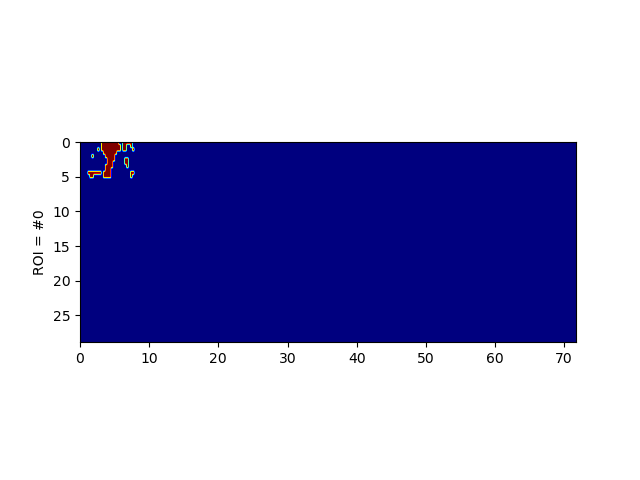

In [16]:
roi_deck_fig, roi_deck_ax = plt.subplots(1)
roi_deck_plot = StackPlotter(
    roi_deck_fig,
    roi_deck_ax,
    masks,
    delta=1,
    vmin=0,
    # vmax=0.1,
    z_fmt_fun=(lambda i: "ROI = #%i" % i),
    cmap="jet",
    dims=(rec_width, rec_height),
)

### ROI extraction and post-processing

In [17]:
mask_beams = pixels_to_beams(stacks[0], roi_idxs, use_weights=False)
mask_beams = np.expand_dims(mask_beams, 0)
mask_beams /= np.var(mask_beams[:, :, -150:], axis=2).reshape(*mask_beams.shape[:2], 1)
mask_beams -= np.mean(mask_beams[:, :, -150:], axis=2).reshape(*mask_beams.shape[:2], 1)
print("mask beams shape:", mask_beams.shape)

mask beams shape: (1, 23, 8000)


In [18]:
tau1 = 2 # rise [ms]
# tau2 = 30  # decay [ms]
tau2 = 50  # decay [ms]
quantum_pts = 100

fitter = BiexpFitter(1, 10, norm_amp=True)
biexp_quantum = fitter.model(
    t=np.arange(quantum_pts), 
    tau1=tau1 / 1000 / dt, # convert to match resulting sample-rate to data
    tau2=tau2 / 1000 / dt, 
    y0=1.,
)[0]
biexp_xaxis = np.arange(quantum_pts) * dt

template = biexp_quantum / biexp_quantum.max()
template = np.concatenate([np.zeros(quantum_pts), template])
template = np.flip(template)

In [19]:
beam_detrend = map_axis(lambda a: a - rolling_average(a, n=120), mask_beams)
beam_conv = map_axis(lambda a: np.convolve(a, template, mode="same"), mask_beams)
# detrend_conv = map_axis(lambda a: a - rolling_average(a, n=120), grid_conv)
detrend_conv = map_axis(lambda a: np.convolve(a, template, mode="same"), beam_detrend)

(-0.2, 0.6)

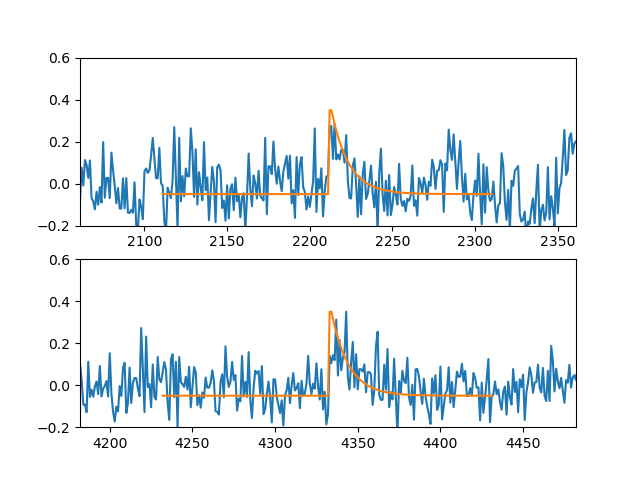

In [20]:
template_fig, template_ax = plt.subplots(2)
# norm_rec = mask_beams[0][0] / mask_beams[0][0].max()
norm_rec = beam_detrend[0][0] / beam_detrend[0][0].max()
flipped_template = np.flip(template) * 0.4
win = 150
ex_a = 2211
ex_b = 4332
template_ax[0].plot(norm_rec)
template_ax[0].plot(np.arange(len(template)) + ex_a - quantum_pts, flipped_template - 0.05)
template_ax[0].set_xlim(ex_a - win, ex_a + win)
template_ax[0].set_ylim(-0.2, 0.6)
template_ax[1].plot(norm_rec)
template_ax[1].plot(np.arange(len(template)) + ex_b - quantum_pts, flipped_template - 0.05)
template_ax[1].set_xlim(ex_b - win, ex_b + win)
template_ax[1].set_ylim(-0.2, 0.6)

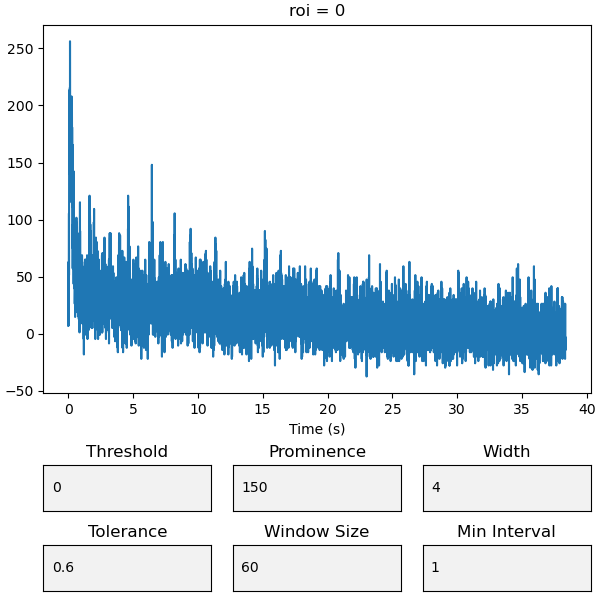

In [21]:
start_idx = 0
peak_explorer = PeakExplorer(
    recs_xaxis[start_idx:],
    mask_beams[0, :, start_idx:],
    # beam_detrend[0, :, start_idx:],
    # detrend_conv[0, :, start_idx:],
    prominence=150,
    width=4,
    tolerance=.6,
    distance=1,
    wlen=60,
    auto_y_scale=True,
)

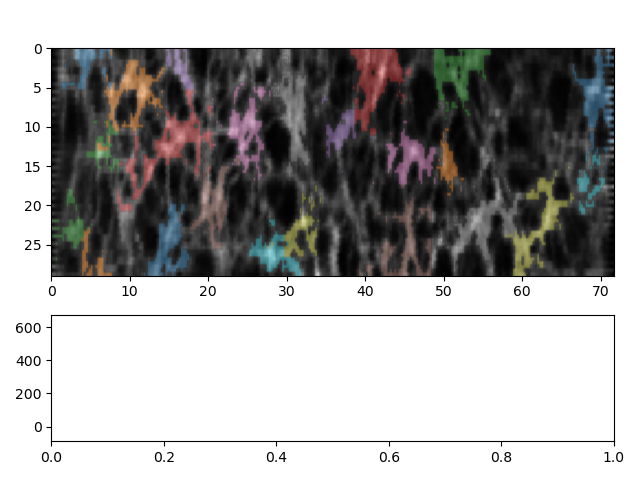

In [22]:
from matplotlib.backend_bases import MouseButton
from scipy import ndimage

class MaskExplorer:
    fig: plt.Figure

    def __init__(
        self,
        proj,
        masks,
        beams,
        zaxis=None,
        vmin=None,
        vmax=None,
        auto_roi_scale=False,
        trial_fmt_fun=None,
        dims=None,
        bg_alpha=0.6,
        fg_alpha=0.8,
        trial_width=1.5,
        avg_width=3,
        **plot_kwargs
    ):
        self.auto_roi_scale = auto_roi_scale

        vmin = beams.min() if vmin is None else vmin
        vmax = beams.max() if vmax is None else vmax

        self.trials = beams.ndim > 3 and beams.shape[0] > 1

        if self.trials:
            self.avg = bn.nanmean(beams, axis=0, keepdims=True)
            beams = np.concatenate([beams, self.avg], axis=0)

            if "gridspec_kw" not in plot_kwargs:
                plot_kwargs["gridspec_kw"] = {
                    "height_ratios": [0.67, 0.03, 0.3]
                }
            self.fig, self.ax = plt.subplots(
                2 + self.trials, **plot_kwargs
            )

            self.roi_ax, self.trial_slide_ax, self.beam_ax = self.ax

            self.trial_fmt_fun = (
                (lambda i: "trial %i" % i)
                if trial_fmt_fun is None
                else trial_fmt_fun
            )
        else:
            beams = beams.reshape(1, *beams.shape) if beams.ndim < 3 else beams
            if "gridspec_kw" not in plot_kwargs:
                plot_kwargs["gridspec_kw"] = {"height_ratios": [0.7, 0.3]}
            self.fig, self.ax = plt.subplots(2, **plot_kwargs)  # type: ignore
            self.roi_ax, self.beam_ax = self.ax

        self.proj, self.masks, self.beams = proj, masks, beams
        self.binary_masks = (np.sum(self.masks, axis=-1) > 0).astype(int)
        self.bg_alpha, self.fg_alpha = bg_alpha, fg_alpha
        self.trial_width, self.avg_width = trial_width, avg_width
        self.y_sz, self.x_sz = proj.shape
        self.tr_sz, self.n_rois, self.z_sz = beams.shape
        self.tr_idx = 0
        self.zaxis = np.arange(self.z_sz) if zaxis is None else zaxis

        self.width, self.height = (self.x_sz, self.y_sz) if dims is None else dims
        self.x_frac = self.width / (self.x_sz)
        self.y_frac = self.height / (self.y_sz)
        self.extent = (0, self.width, self.height, 0)
        self.shown = {}

        self.beam_ax.set_ylim(vmin, vmax)
        self.build_roi_ax(vmin, vmax, self.extent)
        
        if self.trials:
            self.build_trial_slide_ax()
        self.fig.tight_layout(h_pad=0)
        self.connect_events()
        self.ctr = 0


    def build_roi_ax(self, vmin, vmax, extent):
        self.im = self.roi_ax.imshow(self.proj, cmap="gray", extent=extent)
        self.overlay = self.roi_ax.imshow(self.masks.sum(axis=0), extent=extent)
        
    def build_trial_slide_ax(self):
        self.trial_slider = Slider(
            self.trial_slide_ax,
            "",
            valmin=0,
            valmax=(self.tr_sz - 1),
            valinit=0,
            valstep=1,
            valfmt="%.0f",
        )
        self.trial_slide_ax.set_title(self.trial_fmt_fun(0))

    def hide_roi(self, idx):
        for l in self.shown[idx]["lines"]:
            self.beam_ax.lines.remove(l)
        self.shown[idx]["highlight"].remove()
        del self.shown[idx]
        # add back trial lines if back down to one ROI
        if len(self.shown) == 1:
            roi = next(self.shown.values())
            for i, l in enumerate(rois["lines"]):
                if i != self.tr_idx:
                    self.beam_ax.add_line(l)
                    
    def show_roi(self, idx):
        n_shown = len(self.shown)
        c = np.max(self.masks[idx], axis=(0, 1))[:-1]
        roi = {"idx": idx, "c": c, "lines": []}
        for i, b in enumerate(self.beams[:, idx, :]):
            line = self.beam_ax.plot(self.zaxis, b, lw=self.trial_width)[0]
            line.set_color(c if i == self.tr_idx else "black")
            line.set_alpha(self.fg_alpha if i == self.tr_idx else self.bg_alpha)
            roi["lines"].append(line)
            
        if self.trials:
            roi["lines"][-1].set_linewidth(self.avg_width) 
            # hide non-selected trials if there is more than one roi now
            if n_shown > 0:
                rs: List[Any] = [roi, self.rois[0]] if n_rois == 1 else [roi]
                for r in rs:
                    for i, l in enumerate(r["lines"]):
                        if i != self.tr_idx:
                            self.beam_ax.lines.remove(l)
                            
        mask_edge = np.abs(ndimage.sobel(self.binary_masks[idx], mode="reflect"))
        mask_edge = np.expand_dims(mask_edge, 2) * np.array([1, 1, 1, 0.2]).reshape(1, 1, 4)
        roi["highlight"] = self.roi_ax.imshow(mask_edge, extent=self.extent)
        self.shown[idx] = roi
        
    def toggle_roi(self, idx):
        if idx >= 0:
            if idx in self.shown:
                self.hide_roi(idx)
            else:
                self.show_roi(idx)

    def on_trial_slide(self, v):
        self.tr_idx = int(v)
        self.trial_slide_ax.set_title(
            self.trial_fmt_fun(self.tr_idx)
            if self.tr_idx < self.tr_sz - 1
            else "average"
        )
        for roi in self.rois:
            for i, line in enumerate(roi["lines"]):
                line.set_color(roi["c"] if i == self.tr_idx else "black")
                line.set_alpha(self.fg_alpha if i == self.tr_idx else self.bg_alpha)

    def in_roi(self, x, y):
        px = self.binary_masks[:, y, x]
        hits = np.argwhere(px)
        if len(hits):
            return hits[0, 0]
        else:
            return -1

    def on_im_click(self, event):
        if event.inaxes == self.roi_ax:
            if event.button == MouseButton.LEFT:
                x = np.floor(event.xdata / self.x_frac).astype(int)
                y = np.floor(event.ydata / self.y_frac).astype(int)
                idx = self.in_roi(x, y)
                self.toggle_roi(idx)

    def connect_events(self):
        self.fig.canvas.mpl_connect("button_release_event", self.on_im_click)
        if self.trials:
            self.trial_slider.on_changed(self.on_trial_slide)

mask_explorer = MaskExplorer(
    mean_stack_proj, 
    masks_rgba,
    mask_beams, 
    recs_xaxis,
    dims=(rec_width, rec_height),
    trial_width=1.0,
)